In [1]:

import pandas as pd
import numpy as np
import time
import os
import re
from tqdm.cli import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
import umap

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from transformers import TFDistilBertModel, DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

print("TensorFlow Version:", tf.__version__)
print("All libraries imported successfully.")
# Import our updated project modules
from data.preprocessing import load_and_prepare_data, create_book_pairs, create_book_triplets, get_metadata_features, get_text_features
from model.arc import MLPEncoder, BERTEncoder, CNNEncoder, HybridEncoder, SiameseModel, euclidean_distance 
from train.loss import contrastive_loss, triplet_loss, circle_loss
from evaluate.plots import plot_roc_curves, plot_embeddings



c:\Users\premy\Documents\uni\raml\Recc\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



TensorFlow Version: 2.19.0
All libraries imported successfully.


In [2]:
# --- Cell: Configuration ---

# Data and Training Settings

# Use a smaller sample for faster experiments. Set to None to use all data.
# Note: Triplet generation is slower, so a smaller sample is recommended.
SAMPLE_SIZE = 30000
EPOCHS = 4                 # Set to 1-2 for testing, 5-10 for final results.
BATCH_SIZE = 64

# Model Settings
EMBEDDING_DIM = 128
MAX_TITLE_LENGTH = 25
MLP_LEARNING_RATE = 1e-3
CNN_LEARNING_RATE = 1e-3
BERT_LEARNING_RATE = 5e-5


# Set the correct path
DATA_PATH = "data/kaggle_data/" 

print("Configuration set with specific learning rates for each model.")

Configuration set with specific learning rates for each model.


In [3]:
# --- Load Data and Prepare Features ---

reviews_df, books_df = load_and_prepare_data(data_path=DATA_PATH)
if reviews_df is None: raise ValueError("Data loading failed.")

# --- Prepare Features (do this once) ---
print("Preparing metadata features...")
metadata_features = get_metadata_features(books_df)
print("Preparing text features...")
text_features = get_text_features(books_df)

# --- Prepare PAIR data for Contrastive/Circle Loss ---
print("\n--- Generating PAIR data ---")
pair_df = create_book_pairs(reviews_df, min_ratings=5, sample_size=SAMPLE_SIZE)
train_pairs, test_pairs = train_test_split(pair_df, test_size=0.2, random_state=42)


Preparing metadata features...
Preparing text features...

--- Generating PAIR data ---
Generating positive pairs...


100%|██████████| 5949/5949 [00:00<00:00, 9878.50it/s] 


Generating negative pairs...


100%|██████████| 30000/30000 [00:00<00:00, 717608.83it/s]


In [4]:

# --- Prepare TRIPLET data for Triplet Loss ---
print("\n--- Generating TRIPLET data ---")
triplet_df = create_book_triplets(reviews_df, min_ratings=5, sample_size=SAMPLE_SIZE)
train_triplets, test_triplets = train_test_split(triplet_df, test_size=0.2, random_state=42)

print("\nAll data generated.")


--- Generating TRIPLET data ---
Preparing data for triplet generation...
Generating triplets...


100%|██████████| 5949/5949 [00:17<00:00, 340.60it/s] 



All data generated.


In [5]:
# --- Prepare Data for TensorFlow (Final Version) ---

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
vocab_size = tokenizer.vocab_size # Needed for CNN/Hybrid Embedding layers

def prepare_pair_data_tf(df, metadata_map, text_map):
    """Prepares ALL pair-based data into NumPy arrays for all architectures."""
    # ... (This function is already correct and remains unchanged) ...
    book_a_meta = np.array([metadata_map.loc[id].values for id in df['book_a']]).astype(np.float32)
    book_b_meta = np.array([metadata_map.loc[id].values for id in df['book_b']]).astype(np.float32)
    titles_a = text_map.loc[df['book_a']]['title'].tolist()
    titles_b = text_map.loc[df['book_b']]['title'].tolist()
    tokens_a = tokenizer(titles_a, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    tokens_b = tokenizer(titles_b, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    return {
        "mlp_input": [book_a_meta, book_b_meta],
        "cnn_input": [tokens_a['input_ids'], tokens_b['input_ids']],
        "bert_input": [{'input_ids': tokens_a['input_ids'], 'attention_mask': tokens_a['attention_mask']}, {'input_ids': tokens_b['input_ids'], 'attention_mask': tokens_b['attention_mask']}],
        "labels": df['label'].values
    }

def prepare_triplet_data_tf(df, metadata_map, text_map):
    """Prepares ALL triplet-based data into NumPy arrays for all architectures."""
    # --- THIS FUNCTION IS NOW UPGRADED TO HANDLE TEXT ---
    
    # Metadata for MLP
    anchor_meta = np.array([metadata_map.loc[id].values for id in df['anchor']]).astype(np.float32)
    positive_meta = np.array([metadata_map.loc[id].values for id in df['positive']]).astype(np.float32)
    negative_meta = np.array([metadata_map.loc[id].values for id in df['negative']]).astype(np.float32)
    
    # Text for CNN/BERT
    titles_anchor = text_map.loc[df['anchor']]['title'].tolist()
    titles_positive = text_map.loc[df['positive']]['title'].tolist()
    titles_negative = text_map.loc[df['negative']]['title'].tolist()
    tokens_anchor = tokenizer(titles_anchor, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    tokens_positive = tokenizer(titles_positive, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    tokens_negative = tokenizer(titles_negative, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    
    return {
        "mlp_input": [anchor_meta, positive_meta, negative_meta],
        "cnn_input": [tokens_anchor['input_ids'], tokens_positive['input_ids'], tokens_negative['input_ids']],
        "bert_input": [
            {'input_ids': tokens_anchor['input_ids'], 'attention_mask': tokens_anchor['attention_mask']},
            {'input_ids': tokens_positive['input_ids'], 'attention_mask': tokens_positive['attention_mask']},
            {'input_ids': tokens_negative['input_ids'], 'attention_mask': tokens_negative['attention_mask']}
        ],
        "labels": np.ones(len(df)) # Dummy labels for triplet loss
    }



In [6]:


print("Preparing pair data for TF...")
train_pair_data = prepare_pair_data_tf(train_pairs, metadata_features, text_features)
test_pair_data = prepare_pair_data_tf(test_pairs, metadata_features, text_features)

Preparing pair data for TF...


In [7]:

print("Preparing triplet data for TF...")
train_triplet_data = prepare_triplet_data_tf(train_triplets, metadata_features, text_features)
test_triplet_data = prepare_triplet_data_tf(test_triplets, metadata_features, text_features)

print("All data ready for training.")

Preparing triplet data for TF...
All data ready for training.


In [8]:
# --- Run All Experiments (Final, Complete Version) ---
experiments = {}

# Define the complete matrix of experiments to run.
# You can comment out lines to skip experiments and save time.
experiment_matrix = [
    # --- Contrastive Loss Experiments ---
    ("MLP - Contrastive",    MLPEncoder,    contrastive_loss, MLP_LEARNING_RATE,  "pair",    "mlp"),
    ("CNN - Contrastive",    CNNEncoder,    contrastive_loss, CNN_LEARNING_RATE,  "pair",    "cnn"),
    ("BERT - Contrastive",   BERTEncoder,   contrastive_loss, BERT_LEARNING_RATE, "pair",    "bert"),
    ("Hybrid - Contrastive", HybridEncoder, contrastive_loss, MLP_LEARNING_RATE,  "pair",    "hybrid"),
    
    # --- Circle Loss Experiments ---
    ("MLP - Circle",         MLPEncoder,    circle_loss,      MLP_LEARNING_RATE,  "pair",    "mlp"),
    ("CNN - Circle",         CNNEncoder,    circle_loss,      CNN_LEARNING_RATE,  "pair",    "cnn"),

    # --- Triplet Loss Experiments (AUC not applicable) ---
    ("MLP - Triplet",        MLPEncoder,    triplet_loss,     MLP_LEARNING_RATE,  "triplet", "mlp"),
    ("CNN - Triplet",        CNNEncoder,    triplet_loss,     CNN_LEARNING_RATE,  "triplet", "cnn"),
]

# Loop through the matrix and run each defined experiment
for name, Encoder, loss_func, lr, data_type, model_type in experiment_matrix:
    print(f"\n{'='*25}\n--- Running Experiment: {name} ---\n{'='*25}")
    
    tf.keras.backend.clear_session()
    
    # --- 1. Select Data ---
    train_data = train_pair_data if data_type == "pair" else train_triplet_data
    test_data = test_pair_data if data_type == "pair" else test_triplet_data
    train_len = len(train_pairs) if data_type == "pair" else len(train_triplets)
    test_len = len(test_pairs) if data_type == "pair" else len(test_triplets)
    
    # --- 2. Build Model ---
    # Instantiate the correct encoder
    if model_type == "mlp":
        encoder = Encoder(input_shape=(metadata_features.shape[1],), embedding_dim=EMBEDDING_DIM)
        train_input, test_input = train_data["mlp_input"], test_data["mlp_input"]
    elif model_type == "cnn":
        encoder = Encoder(max_length=MAX_TITLE_LENGTH, vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM)
        train_input, test_input = train_data["cnn_input"], test_data["cnn_input"]
    elif model_type == "bert":
        encoder = Encoder(embedding_dim=EMBEDDING_DIM)
        train_input, test_input = train_data["bert_input"], test_data["bert_input"]
    elif model_type == "hybrid":
        encoder = Encoder(metadata_shape=(metadata_features.shape[1],), max_length=MAX_TITLE_LENGTH, vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM)
        train_input = [(train_data['mlp_input'][0], train_data['cnn_input'][0]), (train_data['mlp_input'][1], train_data['cnn_input'][1])]
        test_input = [(test_data['mlp_input'][0], test_data['cnn_input'][0]), (test_data['mlp_input'][1], test_data['cnn_input'][1])]

    # Build the correct training model structure (Siamese for pairs, Triplet for triplets)
    if data_type == "pair":
        model = SiameseModel(encoder)
        train_ds = tf.data.Dataset.from_tensor_slices((tuple(train_input), train_data['labels']))
        test_ds = tf.data.Dataset.from_tensor_slices((tuple(test_input), test_data['labels']))
    else: # triplet
        # Get the input shapes dynamically from the data
        input_shapes = [inp.shape[1:] if len(inp.shape) > 1 else () for inp in train_input]
        anchor_in, pos_in, neg_in = Input(shape=input_shapes[0]), Input(shape=input_shapes[1]), Input(shape=input_shapes[2])
        anchor_emb, pos_emb, neg_emb = encoder(anchor_in), encoder(pos_in), encoder(neg_in)
        output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))([anchor_emb, pos_emb, neg_emb])
        model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=output)
        train_ds = tf.data.Dataset.from_tensor_slices((tuple(train_input), train_data['labels']))
        test_ds = tf.data.Dataset.from_tensor_slices((tuple(test_input), test_data['labels']))
        
    # Finalize dataset pipeline
    train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # --- 3. Compile and Train ---
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_func)
    steps_per_epoch, validation_steps = train_len // BATCH_SIZE, test_len // BATCH_SIZE
    start_time = time.time()
    history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=test_ds, validation_steps=validation_steps, verbose=1)
    train_time = time.time() - start_time
    
    # --- 4. Evaluate and Store ---
    experiments[name] = {'history': history.history, 'time': train_time, 'encoder': encoder}
    if data_type == "pair":
        y_pred = model.predict(test_ds, steps=validation_steps)
        y_true = test_data['labels'][:len(y_pred)]
        experiments[name].update({'y_pred': y_pred, 'y_true': y_true, 'auc': roc_auc_score(y_true, 1 - y_pred)})
        print(f"RESULTS FOR {name}: AUC = {experiments[name]['auc']:.4f}, Time = {train_time:.2f}s")
    else:
        print(f"RESULTS FOR {name}: Training complete. Time = {train_time:.2f}s (AUC not applicable for triplet loss directly)")


--- Running Experiment: MLP - Contrastive ---

Epoch 1/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4357 - val_loss: 0.3806
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3782 - val_loss: 0.3887
Epoch 3/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3776 - val_loss: 0.3770
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3758 - val_loss: 0.3736
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RESULTS FOR MLP - Contrastive: AUC = 0.5176, Time = 6.82s

--- Running Experiment: CNN - Contrastive ---
Epoch 1/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2159 - val_loss: 0.1437
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0920 - val_loss: 0.1302
Epoch 3/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0520 - val_loss: 0.1319
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.0389 - val_loss: 0.1386
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RESULTS FOR CNN - Contrastive: AUC = 0.9135, Time = 58.42s

--- Running Exp

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

Epoch 1/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 1482s 2s/step - loss: 0.6837 - val_loss: 0.2423
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 9168s 12s/step - loss: 0.2340 - val_loss: 0.2227
Epoch 3/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 1598s 2s/step - loss: 0.2169 - val_loss: 0.2133
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 1717s 2s/step - loss: 0.2070 - val_loss: 0.2067
187/187 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step
RESULTS FOR BERT - Contrastive: AUC = 0.7529, Time = 13966.08s

--- Running Experiment: Hybrid - Contrastive ---
Epoch 1/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.2211 - val_loss: 0.1414
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - loss: 0.0868 - val_loss: 0.1267
Epoch 3/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0434 - val_loss: 0.1270
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0290 - val_loss: 0.1342
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RESULTS FOR Hybrid - Contrastive: AUC = 0.9221, Time = 84.11s

--- Running Experiment: MLP - Circle ---
Epo

In [12]:
# --- Final Evaluation and Plotting ---
# ===============================================
def plot_roc_curves(results: dict, figsize: tuple = (10, 8)):
    """
    Plots the ROC curves for all PAIR-BASED models in the results dictionary.
    """
    plt.figure(figsize=figsize)
    
    # Loop through each model's results
    for name, result in results.items():
        # --- THIS IS THE FIX ---
        # Only try to plot if the keys for ROC evaluation exist for this experiment.
        # This will correctly skip the Triplet Loss experiments.
        if 'auc' not in result:
            print(f"--> Skipping ROC plot for '{name}' (not a pair-based experiment).")
            continue # Move to the next item in the loop

        similarity_score = 1 - result['y_pred']
        fpr, tpr, _ = roc_curve(result['y_true'], similarity_score)
        
        # Use the pre-calculated AUC score for the label
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {result['auc']:.3f})")
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves'); plt.legend(loc="lower right")
    plt.grid(True); plt.show()

def plot_embeddings(encoder, data, labels):
    # ... (This function is already correct and remains unchanged) ...
    print("Generating embeddings for visualization...")
    embeddings = encoder.predict(data)
    print("Running UMAP dimensionality reduction...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', s=15, alpha=0.7)
    plt.title(f'UMAP Projection of Book Embeddings (Encoder: {encoder.name})')
    plt.xlabel('UMAP Dimension 1'); plt.ylabel('UMAP Dimension 2')
    if len(np.unique(labels)) < 20:
        plt.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)))
    plt.grid(True); plt.show()
    
print("All helper functions and classes defined.")

All helper functions and classes defined.



--- Final Experiment Results Summary ---


,Experiment Name,Final Val Loss,ROC-AUC,Time (s)
0,Hybrid - Contrastive,0.1342,0.9221,84.1
1,CNN - Contrastive,0.1386,0.9135,58.4
2,BERT - Contrastive,0.2067,0.7529,13966.1
3,MLP - Contrastive,0.3736,0.5176,6.8
4,MLP - Circle,0.1717,0.5019,12.0
5,CNN - Circle,0.0037,0.4780,85.2
6,MLP - Triplet,0.4021,-1.0000,8.5
7,CNN - Triplet,0.3129,-1.0000,51.6



--- Plotting Training and Validation Loss Curves for All Experiments ---


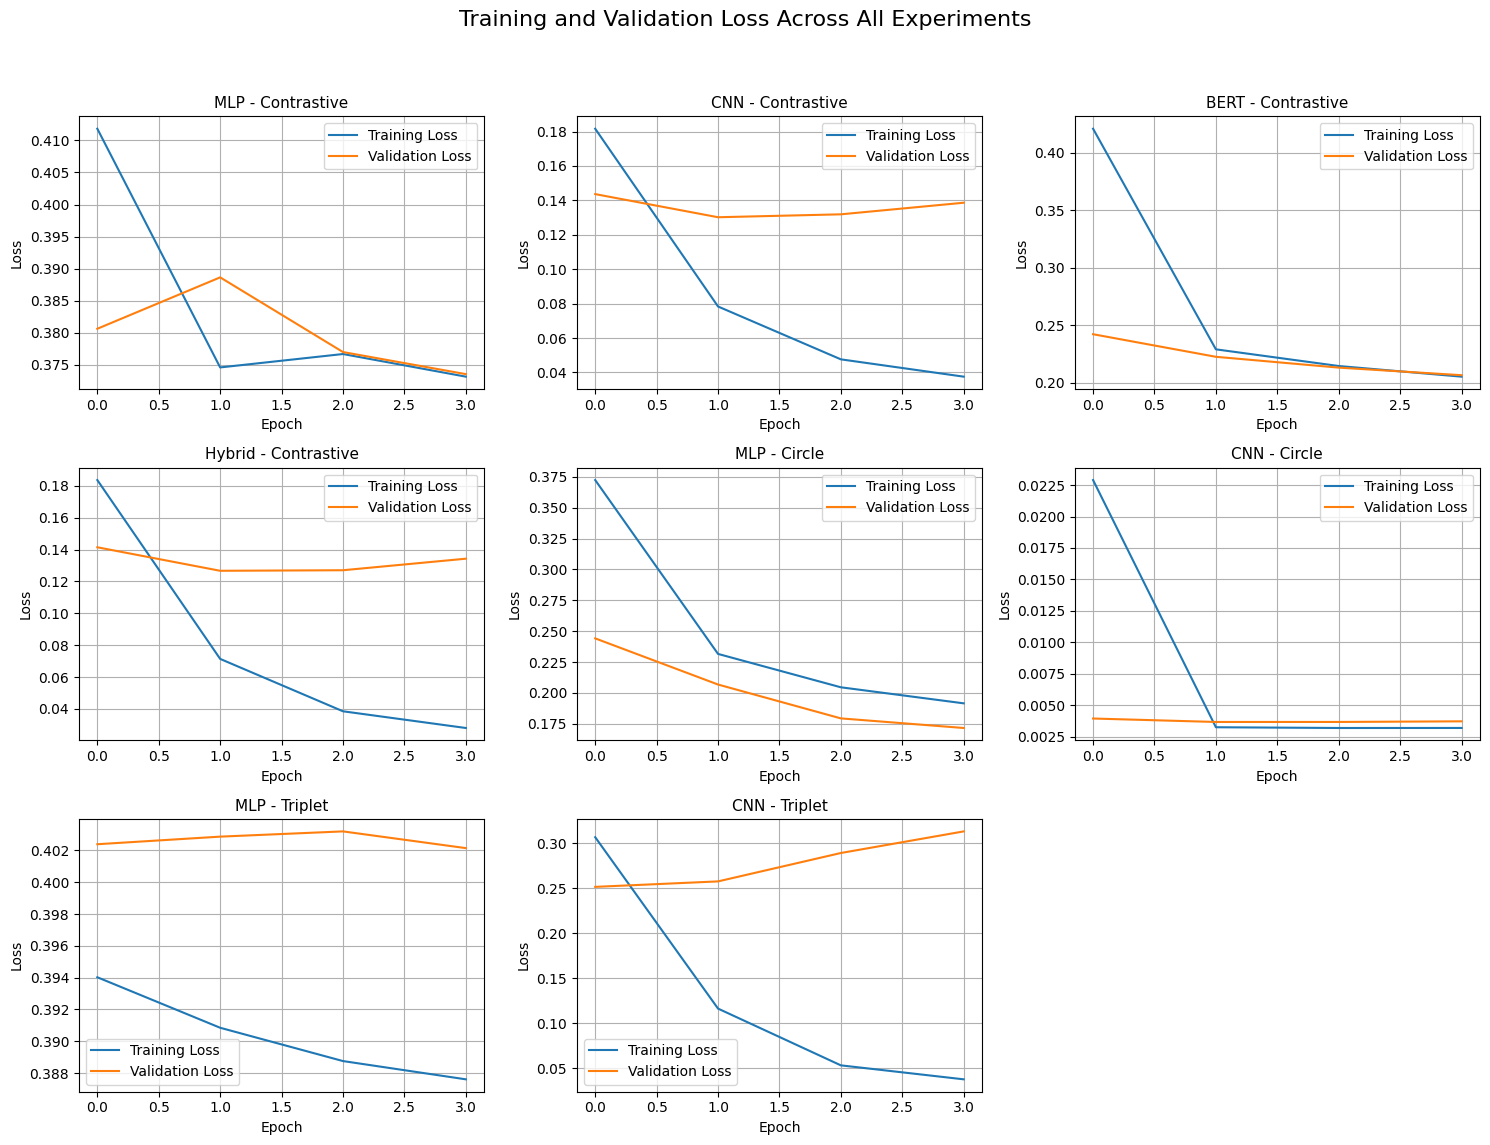


--- Generating ROC Curves (for Pair-based Losses) ---
--> Skipping ROC plot for 'MLP - Triplet' (not a pair-based experiment).
--> Skipping ROC plot for 'CNN - Triplet' (not a pair-based experiment).


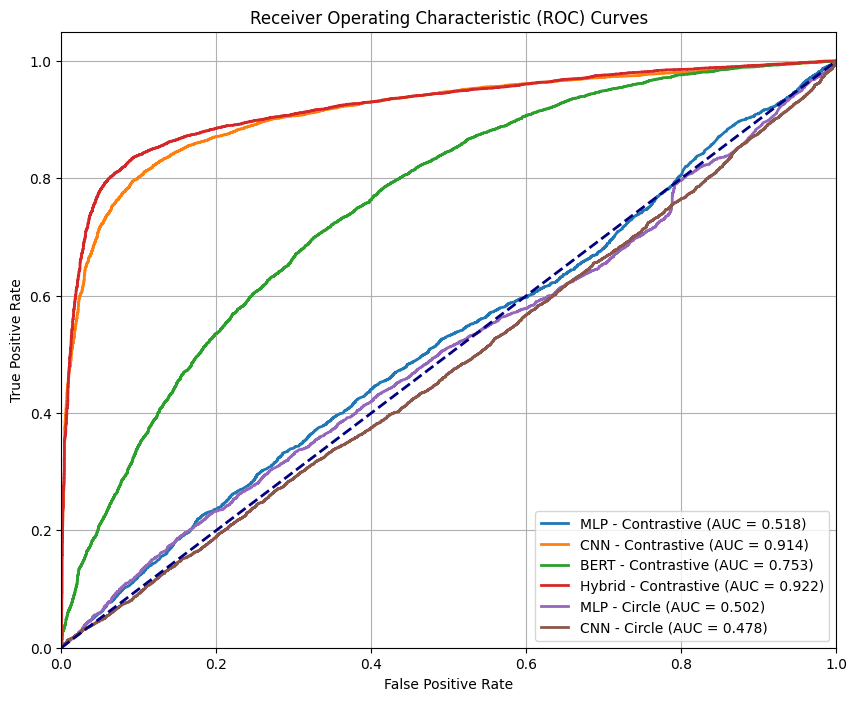


--- Generating Embedding Visualization for Best Performing Encoder ---
Coloring plot by top categories: ['History', 'Unknown', 'Fiction', 'Philosophy', 'Religion', 'Music', 'Other', 'Medical', 'Computers', 'Cooking', 'Science']
Generating embeddings for visualization...
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step
Running UMAP dimensionality reduction...


c:\Users\premy\Documents\uni\raml\Recc\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


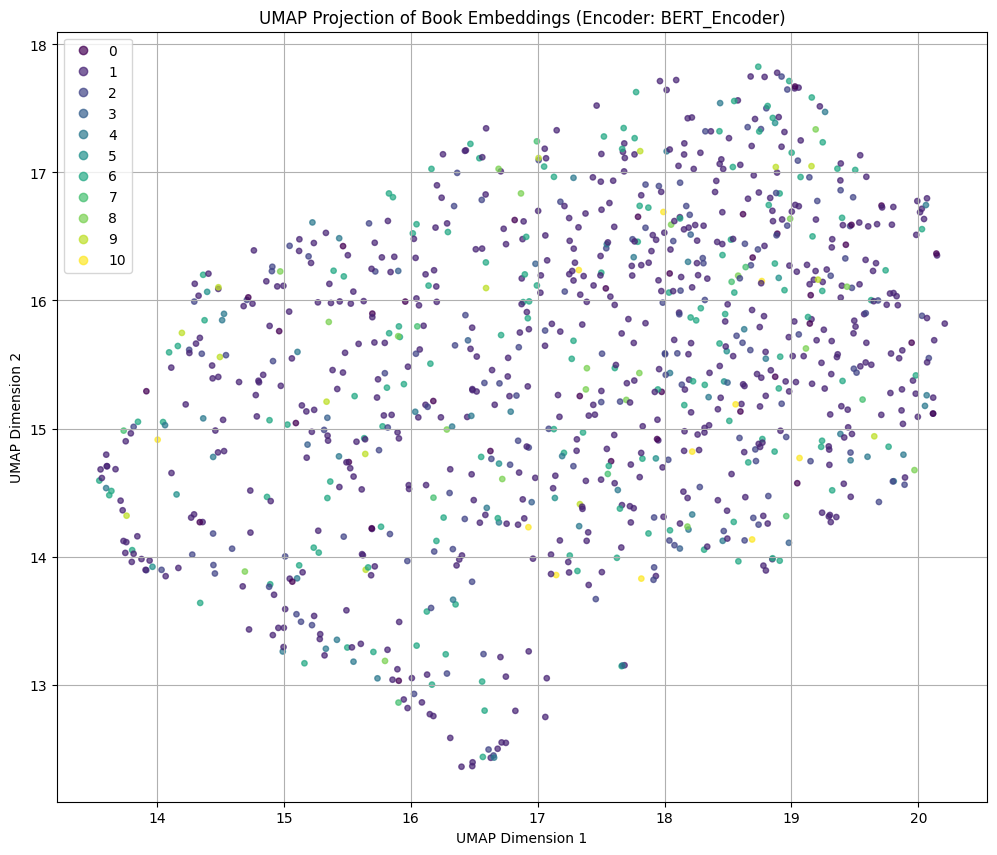

In [10]:
# --- Final Results, Analysis, and Visualization ---

# ================================================
# 1. QUANTITATIVE ANALYSIS: SUMMARY TABLE
# ================================================
# Create a summary DataFrame from the 'experiments' dictionary, which now holds all results.
summary_data = []
for name, result in experiments.items():
    summary_data.append({
        'Experiment Name': name,
        # Get the final validation loss from the history
        'Final Val Loss': round(result['history']['val_loss'][-1], 4),
        # Use .get() to safely access 'auc'. Default to -1 if it doesn't exist (for Triplet Loss)
        'ROC-AUC': round(result.get('auc', -1), 4),
        'Time (s)': round(result['time'], 1)
    })

summary_df = pd.DataFrame(summary_data)
print("\n--- Final Experiment Results Summary ---")
# Display the formatted DataFrame, sorted by the best AUC score
display(summary_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True))


# ================================================
# 2. VISUAL ANALYSIS: TRAINING & VALIDATION LOSS
# ================================================
print("\n--- Plotting Training and Validation Loss Curves for All Experiments ---")
# Determine grid size for subplots
num_experiments = len(experiments)
cols = 3  # Or 4, depending on how you want to lay it out
rows = (num_experiments + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 4))
plt.suptitle('Training and Validation Loss Across All Experiments', fontsize=16)

for i, (name, res) in enumerate(experiments.items()):
    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(res['history']['loss'], label='Training Loss')
    ax.plot(res['history']['val_loss'], label='Validation Loss')
    ax.set_title(name, fontsize=11)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ================================================
# 3. VISUAL ANALYSIS: ROC CURVES
# ================================================
print("\n--- Generating ROC Curves (for Pair-based Losses) ---")
# The plot_roc_curves function will automatically handle models that have an AUC score
plot_roc_curves(experiments)


# ================================================
# 4. QUALITATIVE ANALYSIS: UMAP EMBEDDING SPACE
# ================================================
print("\n--- Generating Embedding Visualization for Best Performing Encoder ---")

# Let's assume the 'BERT - Contrastive' model was one of our best pair-based models
best_experiment_name = "BERT - Contrastive"
if best_experiment_name in experiments:
    # a. Get the trained encoder from our stored results
    best_encoder = experiments[best_experiment_name]['encoder']

    # b. Create a random sample of 1000 books to plot
    sample_book_ids = np.random.choice(text_features.index, 1000, replace=False)
    sample_titles = text_features.loc[sample_book_ids]['title'].tolist()

    # c. Get the REAL categories for these books to use for meaningful coloring
    try:
        sample_categories_df = books_df[books_df['book_id'].isin(sample_book_ids)]
        # Extract the first category from the 'categories' string (e.g., "'Fiction'")
        sample_labels_text = sample_categories_df['categories'].str.extract(r'\'(\w+)\'').fillna('Unknown').iloc[:, 0]
        
        # Keep only the top N most frequent categories for a cleaner plot
        top_categories = sample_labels_text.value_counts().nlargest(10).index
        sample_labels_text[~sample_labels_text.isin(top_categories)] = 'Other'
        
        # Convert the final text labels into numerical codes for plotting
        category_codes, unique_categories = pd.factorize(sample_labels_text)
        print(f"Coloring plot by top categories: {unique_categories.tolist()}")

    except Exception as e:
        print(f"Could not extract real categories due to error: {e}. Using random labels.")
        category_codes = np.random.randint(0, 10, size=1000)

    # d. Tokenize the sampled titles for the BERT encoder
    tokenized_samples = tokenizer(sample_titles, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    bert_input_data = {'input_ids': tokenized_samples['input_ids'], 'attention_mask': tokenized_samples['attention_mask']}

    # e. Call the plotting function with the prepared data
    plot_embeddings(
        encoder=best_encoder,
        data=bert_input_data, 
        labels=category_codes
    )
else:
    print(f"Experiment '{best_experiment_name}' not found. Skipping UMAP plot.")

In [ ]:
# --- file: notebooks/experiments.ipynb ---

# --- Cell: Final Results and Visualization ---

# ================================================
# 1. Quantitative Analysis: Summary Table
# ================================================
# Create a summary DataFrame from the 'experiments' dictionary
summary_df = pd.DataFrame([
    {
        'Architecture': name,
        'ROC-AUC': result['auc'],
        'Training Time (s)': round(result['time'], 1)
    } 
    for name, result in experiments.items()
])

print("\n--- Final Results Summary ---")
# Display the formatted DataFrame
display(summary_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True))


# ================================================
# 2. Visual Analysis: ROC Curves
# ================================================
print("\n--- Generating ROC Curves ---")
# This function will plot all models on a single graph for direct comparison
plot_roc_curves(experiments)


# ================================================
# 3. Visual Analysis: Embedding Space Quality
# ================================================
# We'll visualize the embeddings from our best text-based model: BERT

print("\n--- Generating Embedding Visualization for BERT Encoder ---")

# a. Create a random sample of 1000 books to plot
sample_book_ids = np.random.choice(text_features.index, 1000, replace=False)
sample_titles = text_features.loc[sample_book_ids]['title'].tolist()

# b. For coloring, let's try to find the real categories for these books
#    (If this fails, we can fall back to random labels)
try:
    sample_categories = books_df[books_df['book_id'].isin(sample_book_ids)]
    # A simple way to get the primary category
    sample_labels_text = sample_categories['categories'].str.extract(r'\'(\w+)\'').fillna('Unknown').iloc[:, 0]
    # Convert text labels to numbers for coloring
    labels_map, sample_labels_numeric = pd.factorize(sample_labels_text)
except Exception:
    print("Could not extract real categories, using random labels for coloring.")
    sample_labels_numeric = np.random.randint(0, 10, size=1000)

# c. Tokenize the sampled titles for the BERT encoder
tokenized_samples = tokenizer(sample_titles, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
bert_input_data = {'input_ids': tokenized_samples['input_ids'], 'attention_mask': tokenized_samples['attention_mask']}

# d. Call the plotting function with the prepared data
plot_embeddings(
    encoder=experiments['BERT']['model'].encoder, # Get the encoder from our trained BERT model
    data=bert_input_data, 
    labels=sample_labels_numeric
)